# LSTM

_https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/_

### Setup

In [1]:
# import pandas
import pandas as pd

# import matplotlib
%matplotlib inline
import matplotlib

plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# models
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

# saving
import pickle

# misc
import numpy as np
from scipy.signal import savgol_filter

# const
LOOKBACK_FRAME = 4 * 24
FORECAST_FRAME = 4 * 24

### Load Observations

                            airtemp  cloudcover  precip  107337_00065  \
2008-01-01 06:15:00+00:00 -7.274530    2.741197     0.0      4.881867   
2008-01-01 06:30:00+00:00 -7.352735    2.464017     0.0      4.879670   
2008-01-01 06:45:00+00:00 -7.365834    2.229257     0.0      4.877545   
2008-01-01 07:00:00+00:00 -7.319631    2.035260     0.0      4.875494   
2008-01-01 07:15:00+00:00 -7.219930    1.880372     0.0      4.873519   

                           107338_00010  
2008-01-01 06:15:00+00:00      1.943590  
2008-01-01 06:30:00+00:00      1.918974  
2008-01-01 06:45:00+00:00      1.895998  
2008-01-01 07:00:00+00:00      1.874504  
2008-01-01 07:15:00+00:00      1.854337  


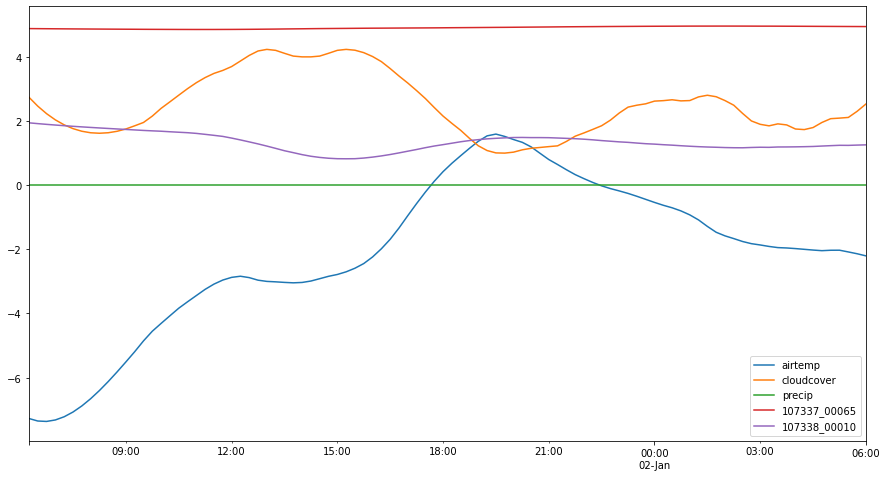

In [2]:
observations = pd.read_pickle('output/observations.pickle')

# to make this data better suited for regression, we'll run it through savitzky golay to smooth
observations = observations.apply(lambda d: savgol_filter(d, 25, 3))

print(observations.head())
observations.head(4 * 24).plot()
plt.show()

### Prepare Dataframe for LSTM

In [3]:
values = observations.values

# ensure values are floats
values = values.astype('float')

# normalize features
in_values = values[:, 0:3]
out_values = values[:, 3:6]
in_scaler = MinMaxScaler(feature_range=(0, 1))
out_scaler = MinMaxScaler(feature_range=(0, 1))
in_scaled = in_scaler.fit_transform(in_values)
out_scaled = out_scaler.fit_transform(out_values)
scaled = pd.DataFrame(np.hstack((in_scaled, out_scaled)))

pickle.dump(in_scaler, open('output/in_scaler.pickle', 'wb'))
pickle.dump(out_scaler, open('output/out_scaler.pickle', 'wb'))

# ! revisit
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def reframe_data(df, lookback, forecast):
	# convert from series to supervised set
	reframed = series_to_supervised(df, lookback, forecast)

	columns = reframed.columns.to_list()
	historical = columns[:5 * lookback + 3]
	projected = []
	predict = []
	for i in range(forecast):
		start_col = 5 * (lookback + 1)
		batch = columns[start_col + (i * 5):start_col + ((i + 1) * 5)]
		projected += batch[:3]
		predict += batch[3:]

	return reframed[historical + projected + columns[5 * lookback + 3:5 * (lookback + 1)] + predict]

reframed = reframe_data(scaled, LOOKBACK_FRAME, FORECAST_FRAME)
print(reframed.head())

     var1(t-96)  var2(t-96)  var3(t-96)  var4(t-96)  var5(t-96)  var1(t-95)  \
96     0.221108    0.568749    0.099144    0.182968    0.073764    0.220149   
97     0.220149    0.521716    0.099144    0.182778    0.072960    0.219989   
98     0.219989    0.481881    0.099144    0.182595    0.072210    0.220555   
99     0.220555    0.448963    0.099144    0.182417    0.071508    0.221777   
100    0.221777    0.422681    0.099144    0.182247    0.070849    0.223584   

     var2(t-95)  var3(t-95)  var4(t-95)  var5(t-95)  ...  var4(t+91)  \
96     0.521716    0.099144    0.182778    0.072960  ...    0.175455   
97     0.481881    0.099144    0.182595    0.072210  ...    0.175216   
98     0.448963    0.099144    0.182417    0.071508  ...    0.174959   
99     0.422681    0.099144    0.182247    0.070849  ...    0.174651   
100    0.402754    0.099144    0.182082    0.070229  ...    0.174403   

     var5(t+91)  var4(t+92)  var5(t+92)  var4(t+93)  var5(t+93)  var4(t+94)  \
96     0.0110

### Split Train/Test

In [4]:
values = reframed.values
train_portion = 0.8 # 80%
divider = int(len(values) * train_portion)

train = values[:divider, :]
test = values[divider:, :]

train_X, train_y = train[:, :-(2 * FORECAST_FRAME)], train[:, -(2 * FORECAST_FRAME):]
test_X, test_y = test[:, :-(2 * FORECAST_FRAME)], test[:, -(2 * FORECAST_FRAME):]

# reshape
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(390071, 1, 768) (390071, 192) (97518, 1, 768) (97518, 192)


### Create Model

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-27 00:49:03.179506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-27 00:49:03.180599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2022-06-27 00:49:04.322339: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-27 00:49:05.010696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-27 00:49:18.264603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 - 15s - loss: 0.0659 - val_loss: 0.0301 - 15s/epoch - 1s/step
Epoch 2/100
12/12 - 13s - loss: 0.0154 - val_loss: 0.0099 - 13s/epoch - 1s/step
Epoch 3/100
12/12 - 13s - loss: 0.0079 - val_loss: 0.0046 - 13s/epoch - 1s/step
Epoch 4/100
12/12 - 14s - loss: 0.0046 - val_loss: 0.0028 - 14s/epoch - 1s/step
Epoch 5/100
12/12 - 13s - loss: 0.0028 - val_loss: 0.0022 - 13s/epoch - 1s/step
Epoch 6/100
12/12 - 13s - loss: 0.0022 - val_loss: 0.0018 - 13s/epoch - 1s/step
Epoch 7/100
12/12 - 13s - loss: 0.0020 - val_loss: 0.0019 - 13s/epoch - 1s/step
Epoch 8/100
12/12 - 13s - loss: 0.0018 - val_loss: 0.0016 - 13s/epoch - 1s/step
Epoch 9/100
12/12 - 13s - loss: 0.0016 - val_loss: 0.0015 - 13s/epoch - 1s/step
Epoch 10/100
12/12 - 13s - loss: 0.0015 - val_loss: 0.0014 - 13s/epoch - 1s/step
Epoch 11/100
12/12 - 13s - loss: 0.0015 - val_loss: 0.0014 - 13s/epoch - 1s/step
Epoch 12/100
12/12 - 13s - loss: 0.0014 - val_loss: 0.0014 - 13s/epoch - 1s/step
Epoch 13/100
12/12 - 13s - loss: 0.0014 - val_los

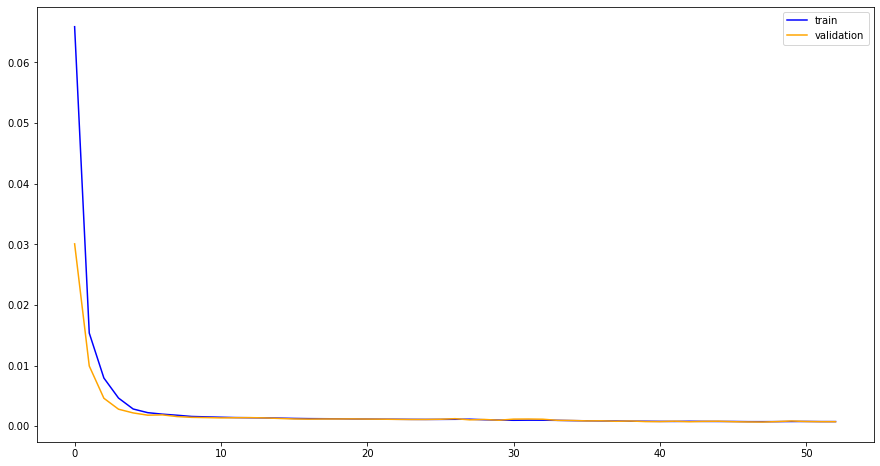

In [5]:
train = pd.DataFrame()
test = pd.DataFrame()

batch_size = 4 * 24 * 365 # process one year at a time to capture annual seasonality

for i in range(1):
  # define model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(400, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(tf.keras.layers.LSTM(400, activation='relu'))
  model.add(tf.keras.layers.Dense(2 * FORECAST_FRAME))
  model.compile(loss='mse', optimizer='adam')

  # early stopping
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

  # fit
  history = model.fit(train_X,
                      train_y,
                      epochs=100,
                      batch_size=batch_size,
                      validation_data=(test_X, test_y),
                      verbose=2,
                      shuffle=False,
                      callbacks=[callback])
  model.reset_states()

  # record results
  train[str(i)] = history.history['loss']
  test[str(i)] = history.history['val_loss']

# save last model
model.save('output/model.h5')

plt.plot(train, color='blue', label='train')
plt.plot(test, color='orange', label='validation')
plt.legend()
plt.show()

### Sanity Check

(5184, 5)
== iter 0 => steps 0 to 192


2022-06-27 01:00:51.341254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


== iter 1 => steps 96 to 288
== iter 2 => steps 192 to 384
== iter 3 => steps 288 to 480
== iter 4 => steps 384 to 576
== iter 5 => steps 480 to 672
== iter 6 => steps 576 to 768
== iter 7 => steps 672 to 864
== iter 8 => steps 768 to 960
== iter 9 => steps 864 to 1056
== iter 10 => steps 960 to 1152
== iter 11 => steps 1056 to 1248
== iter 12 => steps 1152 to 1344
== iter 13 => steps 1248 to 1440
== iter 14 => steps 1344 to 1536
== iter 15 => steps 1440 to 1632
== iter 16 => steps 1536 to 1728
== iter 17 => steps 1632 to 1824
== iter 18 => steps 1728 to 1920
== iter 19 => steps 1824 to 2016
== iter 20 => steps 1920 to 2112
== iter 21 => steps 2016 to 2208
== iter 22 => steps 2112 to 2304
== iter 23 => steps 2208 to 2400
== iter 24 => steps 2304 to 2496
== iter 25 => steps 2400 to 2592
== iter 26 => steps 2496 to 2688
== iter 27 => steps 2592 to 2784
== iter 28 => steps 2688 to 2880
== iter 29 => steps 2784 to 2976
== iter 30 => steps 2880 to 3072
== iter 31 => steps 2976 to 3168
== it

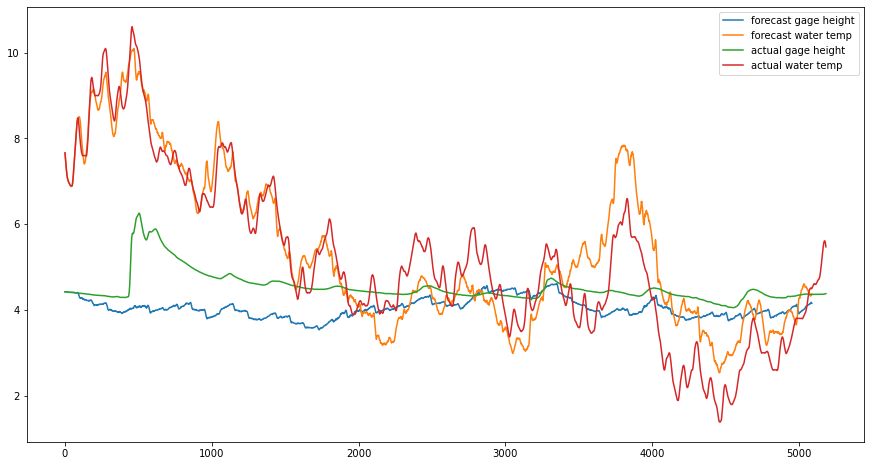

In [7]:
# get the last three days of data from the dataset (previously used for validation)
test = observations.tail(4 * 36 * 36).values
expected = test[:, 3:]

# scale
test = np.hstack((in_scaler.transform(test[:, :3]), out_scaler.transform(test[:, 3:])))

print(test.shape)

predicted = np.array(test[:LOOKBACK_FRAME, 3:])
for i in range(int((test.shape[0] - LOOKBACK_FRAME) / LOOKBACK_FRAME) - 1):
  print('== iter {} => steps {} to {}'.format(i, LOOKBACK_FRAME * i, LOOKBACK_FRAME * (i + 1) + FORECAST_FRAME))

  # reframe data
  test_reframed = reframe_data(pd.DataFrame(test[LOOKBACK_FRAME * i:LOOKBACK_FRAME * (i + 1) + FORECAST_FRAME, :]), LOOKBACK_FRAME, FORECAST_FRAME)

  # prepare input
  test_X = test_reframed.values[:, :-FORECAST_FRAME * 2]
  test_X = test_X.reshape((1, 1, test_X.shape[1]))

  # predict
  pred = model.predict(test_X, verbose=0)
  pred = pred.reshape(96, 2)

  # update data with predicted values
  test[LOOKBACK_FRAME * (i + 1):LOOKBACK_FRAME * (i + 1) + FORECAST_FRAME, 3:] = pred

  # store prediction
  predicted = np.append(predicted, pred, axis=0)

# rescale
predicted = out_scaler.inverse_transform(predicted)

predicted[:, 0] = savgol_filter(predicted[:, 0], 25, 3)
predicted[:, 1] = savgol_filter(predicted[:, 1], 25, 3)

# graph
plt.plot(predicted)
plt.plot(expected)
plt.legend(['forecast gage height', 'forecast water temp', 'actual gage height', 'actual water temp'])
plt.show()